# Visualization of infection timelines

For figure A3 in the supplement.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import networkx as nx
import pandas as pd
import json
from os.path import join

from scseirx.model_nursing_home import SEIRX_nursing_home
from scseirx import viz

## Simulation parameters

In [5]:
with open('params/testing_strategy_simulation_parameters.json') as json_file:
    simulation_params = json.load(json_file)
    
with open('params/testing_strategy_measures.json') as json_file:
    measures = json.load(json_file)


In [14]:
agent_types = {
        'employee':{
            'screening_interval': 3,
            'index_probability': 0,
            'mask':False},
        'resident':{
            'screening_interval': 7,
            'index_probability': 0,
            'mask':False},
}

## Run the simulation

In [19]:
N_steps = 100
seed = 6
contact_network_src = '../data/contact_networks'

G = nx.readwrite.gpickle.read_gpickle(join(contact_network_src,
                            'interactions_single_quarter.bz2'))

model = SEIRX_nursing_home(G, simulation_params['verbosity'], 
      base_transmission_risk = simulation_params['base_transmission_risk'], 
      testing = measures['testing'],
      exposure_duration = simulation_params['exposure_duration'],
      time_until_symptoms = simulation_params['time_until_symptoms'],
      infection_duration = simulation_params['infection_duration'],
      quarantine_duration = measures['quarantine_duration'],
      subclinical_modifier = simulation_params['subclinical_modifier'], 
      infection_risk_contact_type_weights = \
            simulation_params['infection_risk_contact_type_weights'], 
      K1_contact_types = measures['K1_contact_types'],
      diagnostic_test_type = measures['diagnostic_test_type'],
      preventive_screening_test_type = \
            measures['preventive_screening_test_type'],
      follow_up_testing_interval = \
            measures['follow_up_testing_interval'],
      liberating_testing = measures['liberating_testing'],
      index_case = 'employee',
      agent_types = agent_types, 
      mask_filter_efficiency = measures['mask_filter_efficiency'],
      transmission_risk_ventilation_modifier = \
            measures['transmission_risk_ventilation_modifier'],
      seed=seed)

for i in range(N_steps):
    if simulation_params['verbosity'] > 0: 
        print()
        print('*** step {} ***'.format(i+1))
    # break if first outbreak is over
    if len([a for a in model.schedule.agents if \
        (a.exposed == True or a.infectious == True)]) == 0:
        break
    model.step()

## Visualize infection dynamics

In [34]:
def draw_infection_timeline(model, agent_type, ax):
    linewidth = 3
    pop_numbers = model.datacollector.get_model_vars_dataframe()

    N = len(set([x for x,y in model.G.nodes(data=True) \
        if y['type'] == agent_type]))

    pop_numbers['S_{}'.format(agent_type)] = N - pop_numbers['E_{}'.format(agent_type)]\
                                               - pop_numbers['I_{}'.format(agent_type)]\
                                               - pop_numbers['R_{}'.format(agent_type)]

    ax.plot(pop_numbers['S_{}'.format(agent_type)]/N * 100,\
         label='S', color=colors['susceptible'], linewidth=linewidth, zorder=1)

    ax.plot(pop_numbers['E_{}'.format(agent_type)]/N* 100,\
         label='E', color=colors['exposed'], linewidth=linewidth, zorder=1)

    ax.plot(pop_numbers['I_symptomatic_{}'.format(agent_type)]/N* 100, \
         label='$I_1$', color=colors['infectious'],
          linewidth=linewidth, zorder=1)

    ax.plot(pop_numbers['I_asymptomatic_{}'.format(agent_type)]/N* 100, \
         label='$I_2$', color=colors['infectious'], alpha=0.3,
          linewidth=linewidth, zorder=1)

    ax.plot(pop_numbers['R_{}'.format(agent_type)]/N* 100, \
         label='R', color=colors['recovered'], linewidth=linewidth, zorder=1)

    ax.plot(pop_numbers['X_{}'.format(agent_type)]/N* 100, \
         label='X', color=colors['quarantined'], linewidth=linewidth, zorder=1)

    # draw screen lines
    screen_colours = {'reactive':'grey', 'follow_up':'blue', 'preventive':'green'}
    screen_types = ['reactive', 'follow_up', 'preventive']
    for screen_type in screen_types:
        for i, screen in enumerate(pop_numbers['screen_{}s_{}'.format(agent_type, screen_type)]):
            if screen:
                ax.plot([i, i], [0, 100], color=screen_colours[screen_type], alpha=0.3,
                 linewidth=4, zorder=2)

    # legend with custom artist for the screening lines
    handles, labels = ax.get_legend_handles_labels()
    preventive_screen_handle = plt.Line2D((0,1),(0,0), color=screen_colours['preventive']
        , alpha=0.3, linewidth=4)

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles)] + [preventive_screen_handle],
              [label for i,label in enumerate(labels)] + \
              ['preventive screen'], ncol=2, loc=6, 
              fontsize=14, bbox_to_anchor=[0, 0.55])

    ax.set_xlabel('steps', fontsize=20)
    ax.set_ylabel('% of population', fontsize=20)
    #ax.set_ylim(-1, 100)
    #ax.set_xlim(0, 60)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_title('{}s'.format(agent_type.replace('_', ' ')), fontsize=18)

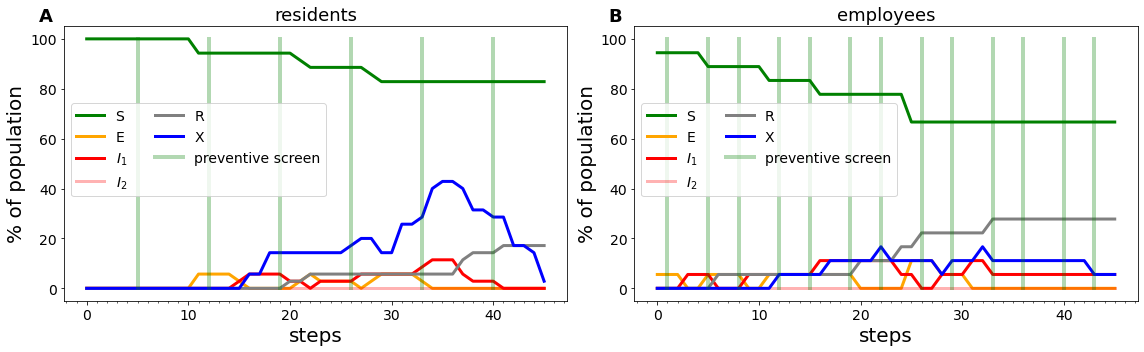

In [58]:
colors = {'susceptible':'g',
          'exposed':'orange', 
          'infectious':'red',
          'recovered':'gray',
          'quarantined':'blue',
          'testable':'k'}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
draw_infection_timeline(model, 'resident', axes[0])
draw_infection_timeline(model, 'employee', axes[1])

fig.text(0.037, 0.93, 'A', fontsize=18, fontweight='bold')
fig.text(0.531, 0.93, 'B', fontsize=18, fontweight='bold')

fig.tight_layout()

plt.savefig('../plots/infection_dynamics.pdf')
plt.savefig('../plots/infection_dynamics.svg')
plt.savefig('../plots/infection_dynamics.png', dpi=300)